<a href="https://colab.research.google.com/github/podobongbong/the_project/blob/main/multi_variable_Resid_backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/podobongbong/the_project.git

Cloning into 'the_project'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 39 (delta 15), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 880.16 KiB | 2.76 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [ ]:
import os
os.chdir('/content/the_project') # Changed directory to where the CSV file likely exists
import pandas as pd

# Updated path to reflect the CSV's location in the cloned repo
data = pd.read_csv('energy.csv')

data.columns = ['year','city','district','type','jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

#주택용
data = data[data['type']=='주택용']

monthly_columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
aggregated_data = data.groupby(['year','city'])[monthly_columns].sum().reset_index()

# Updated path for the output CSV as well
aggregated_data.to_csv('total_aggregated_city_energy.csv', index=False)


In [ ]:
#%% DATA PREP
import numpy as np
from sklearn.preprocessing import MinMaxScaler
seoul_data = aggregated_data[aggregated_data['city'] == '서울특별시'].drop(columns=['city']).set_index('year')
busan_data = aggregated_data[aggregated_data['city'] == '부산광역시'].drop(columns=['city']).set_index('year')

energy_data_seoul = seoul_data.values.flatten()
energy_data_busan = busan_data.values.flatten()

# Normalize the data using MinMaxScaler
scaler_seoul = MinMaxScaler()  # Use separate scaler for Seoul
scaler_busan = MinMaxScaler()  # Use separate scaler for Busan
# Normalize Seoul data
energy_data_seoul_scaled = scaler_seoul.fit_transform(energy_data_seoul.reshape(-1, 1)).flatten()

# Normalize Busan data
energy_data_busan_scaled = scaler_busan.fit_transform(energy_data_busan.reshape(-1, 1)).flatten()



In [ ]:
#%% SLIDING WINDOW
# Function to create sliding window samples
def create_sliding_window(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])  # Take the previous 'window_size' months
        y.append(data[i])  # The target is the next month's consumption
    return np.array(X), np.array(y)

WINDOW_SIZE = 12
TOTAL_MONTHS = 240

# Create sliding window samples for Seoul and Busan
X_seoul, y_seoul = create_sliding_window(energy_data_seoul_scaled, WINDOW_SIZE)
X_busan, y_busan = create_sliding_window(energy_data_busan_scaled, WINDOW_SIZE)

# Split Busan data into training and test sets (hold out the last 12 months for testing)
X_train_busan = X_busan[:-12]
y_train_busan = y_busan[:-12]
X_test_busan = X_busan[-12:]
y_test_busan = y_busan[-12:]


Pretraining on Seoul's data...
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0726 - mae: 0.2377 - val_loss: 0.1121 - val_mae: 0.2701
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0259 - mae: 0.1167 - val_loss: 0.0491 - val_mae: 0.1404
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0195 - mae: 0.0982 - val_loss: 0.0416 - val_mae: 0.1623
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0175 - mae: 0.1100 - val_loss: 0.0442 - val_mae: 0.1467
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0167 - mae: 0.0875 - val_loss: 0.0518 - val_mae: 0.1423
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0173 - mae: 0.0895 - val_loss: 0.0517 - val_mae: 0.1422
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0132 - mae: 0.0819 - val_loss: 0.0483 - val_mae: 0.1418
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0105 - mae: 0.0762 - val_loss: 0.0451 - val_mae: 0.1450
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 

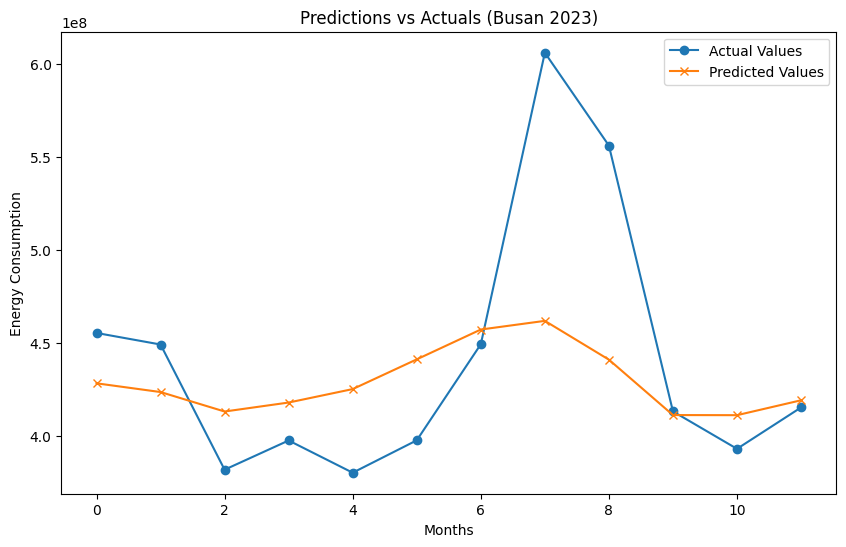

In [ ]:
# 2. Feature extraction
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten
import matplotlib.pyplot as plt
def build_pretrained_model(window_size, num_features):
    input_layer = Input(shape=(window_size, num_features), name='Input')
    lstm_out = LSTM(64, activation='tanh', name='LSTM_Layer')(input_layer)
    output_layer = Dense(1, activation='linear', name='Output')(lstm_out)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Pretrain the model on Seoul's data
print("Pretraining on Seoul's data...")
pretrained_model = build_pretrained_model(WINDOW_SIZE, 1)
history_pretrain = pretrained_model.fit(X_seoul, y_seoul, epochs=50, batch_size=32, validation_split=0.2)

#%% Feature Extraction with the Pre-trained Model
# Freeze the LSTM layer so it acts as a feature extractor
pretrained_model.get_layer('LSTM_Layer').trainable = False

# Remove the output layer and use the LSTM's output as features
feature_extractor = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('LSTM_Layer').output)

# Generate features for Busan's data
X_train_features_busan = feature_extractor.predict(X_train_busan)
X_test_features_busan = feature_extractor.predict(X_test_busan)

#%% Build a New Model for Busan's Task
def build_new_model_for_finetuning(input_shape):
    input_layer = Input(shape=input_shape, name='Input_Features')
    dense_1 = Dense(32, activation='relu', name='Dense_New_1')(input_layer)
    dense_2 = Dense(16, activation='relu', name='Dense_New_2')(dense_1)
    output_layer = Dense(1, activation='linear', name='Output')(dense_2)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create a new model that takes the extracted features as input
new_model = build_new_model_for_finetuning(X_train_features_busan.shape[1:])

# Train the new model on Busan's data
print("Training new layers on Busan's data...")
history_finetune = new_model.fit(X_train_features_busan, y_train_busan, epochs=50, batch_size=32, validation_split=0.2)

#%% Evaluate and Predict on Test Data
print("Evaluating on Busan's test data...")
test_loss, test_mae = new_model.evaluate(X_test_features_busan, y_test_busan)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict on test data
predictions = new_model.predict(X_test_features_busan)

# Rescale predictions and actual values back to original scale
predictions_rescaled = scaler_busan.inverse_transform(predictions.reshape(-1, 1)).flatten()
actual_rescaled = scaler_busan.inverse_transform(y_test_busan.reshape(-1, 1)).flatten()

#%% Visualization
def plot_predictions(y_true, y_pred, title='Predictions vs Actuals (Busan 2023)'):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Values', marker='o')
    plt.plot(y_pred, label='Predicted Values', marker='x')
    plt.title(title)
    plt.xlabel('Months')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.show()

# Visualize results
plot_predictions(actual_rescaled, predictions_rescaled)


In [ ]:

# 1. Partial fine tuning model creation
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt

def build_model_partial_finetune(window_size, num_features):
    input_layer = Input(shape=(window_size, num_features), name='Input')

    # LSTM Layer (pretrained, frozen for fine-tuning)
    lstm_out = LSTM(64, activation='tanh', name='LSTM_Layer')(input_layer)

    # Dense layers (trainable)
    dense_1 = Dense(32, activation='relu', name='Dense_1')(lstm_out)
    dense_2 = Dense(16, activation='relu', name='Dense_2')(dense_1)

    # Output layer for predicting the next month's energy consumption
    output_layer = Dense(1, activation='linear', name='Output')(dense_2)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Freeze the LSTM layer for fine-tuning (Only dense layers are trainable)
    model.get_layer('LSTM_Layer').trainable = False

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model


Pretraining on Seoul's data...


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 12, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_Layer (LSTM)                    │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 2,625 (10.25 KB)

 Non-trainable params: 16,896 (66.00 KB)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0470 - mae: 0.1875 - val_loss: 0.1190 - val_mae: 0.2841
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0342 - mae: 0.1484 - val_loss: 0.0928 - val_mae: 0.2331
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0270 - mae: 0.1155 - val_loss: 0.0710 - val_mae: 0.1800
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0153 - mae: 0.0866 - val_loss: 0.0543 - val_mae: 0.1476
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0173 - mae: 0.0820 - val_loss: 0.0451 - val_mae: 0.1405
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0152 - mae: 0.0893 - val_loss: 0.0421 - val_mae: 0.1429
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0173 - mae: 0.0925 - val_loss: 0.0419 - val_mae: 0.1432
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0182 - mae: 0.0943 - val_loss: 0.0433 - val_mae: 0.1411
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0120 - mae: 0.0816 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


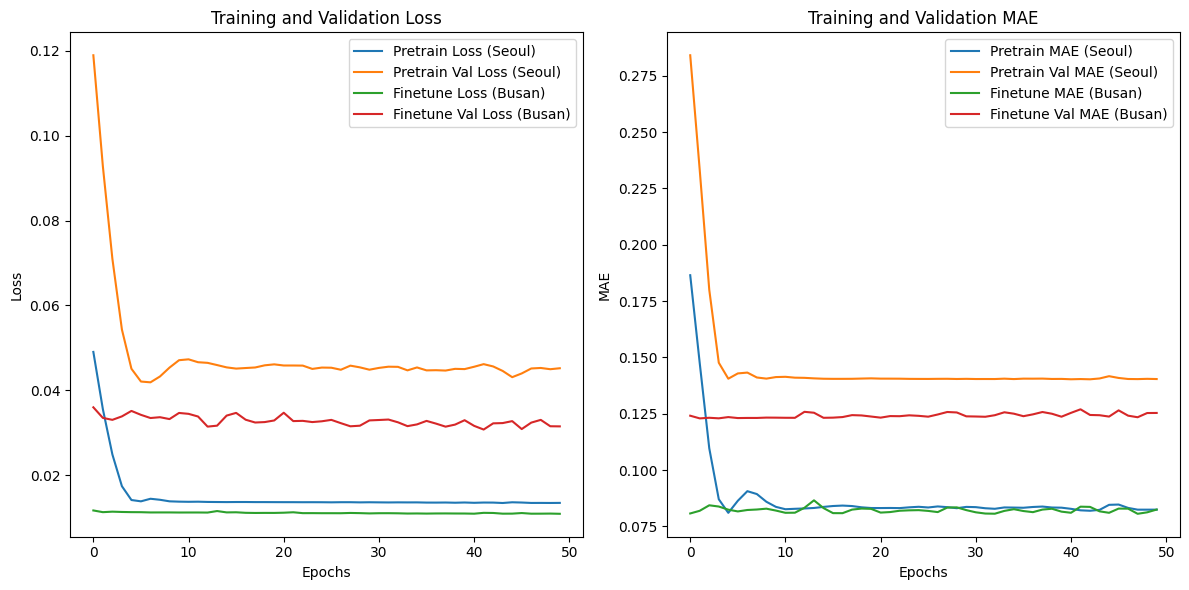

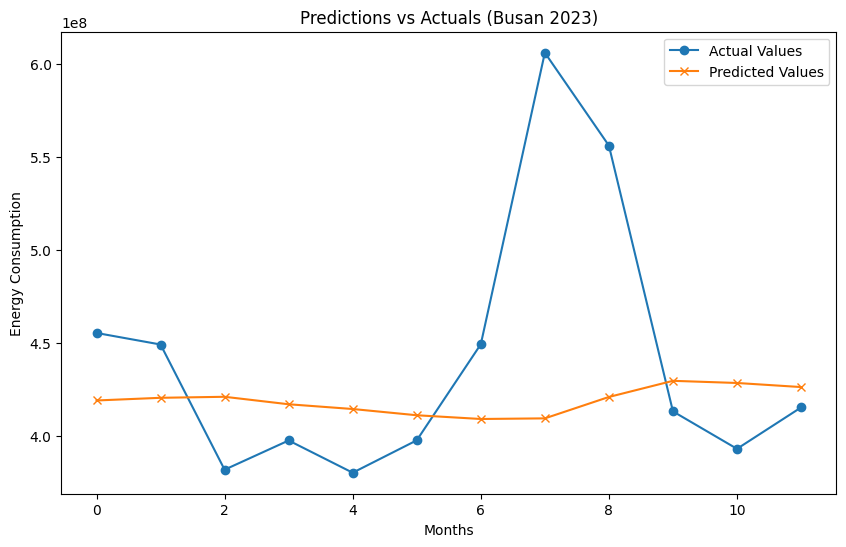

In [ ]:
# Pretrain on Seoul's data (2004-2023)
print("Pretraining on Seoul's data...")
WINDOW_SIZE = 12
# The model expects 1 feature, not 2
model = build_model_partial_finetune(WINDOW_SIZE, 1)
model.summary()
history_pretrain = model.fit(X_seoul, y_seoul, epochs=50, batch_size=32, validation_split=0.2)

# Fine-tune on Busan's data (Only dense layers are trainable)
print("Fine-tuning on Busan's data...")
history_finetune = model.fit(X_train_busan, y_train_busan, epochs=50, batch_size=32, validation_split=0.2)

#%% Evaluate on Busan's Test Data
print("Evaluating on Busan's test data...")
test_loss, test_mae = model.evaluate(X_test_busan, y_test_busan)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict on test data
predictions = model.predict(X_test_busan)

# Rescale predictions and actual values back to original scale
predictions_rescaled = scaler_busan.inverse_transform(predictions.reshape(-1, 1)).flatten()
actual_rescaled = scaler_busan.inverse_transform(y_test_busan.reshape(-1, 1)).flatten()

#%% Visualize the Results
# Plot training and validation loss during pretraining and fine-tuning
def plot_training_history(history_pretrain, history_finetune):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history_pretrain.history['loss'], label='Pretrain Loss (Seoul)')
    plt.plot(history_pretrain.history['val_loss'], label='Pretrain Val Loss (Seoul)')
    plt.plot(history_finetune.history['loss'], label='Finetune Loss (Busan)')
    plt.plot(history_finetune.history['val_loss'], label='Finetune Val Loss (Busan)')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_pretrain.history['mae'], label='Pretrain MAE (Seoul)')
    plt.plot(history_pretrain.history['val_mae'], label='Pretrain Val MAE (Seoul)')
    plt.plot(history_finetune.history['mae'], label='Finetune MAE (Busan)')
    plt.plot(history_finetune.history['val_mae'], label='Finetune Val MAE (Busan)')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot predictions vs actual values for Busan (2023)
def plot_predictions(y_true, y_pred, title='Predictions vs Actuals (Busan 2023)'):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Values', marker='o')
    plt.plot(y_pred, label='Predicted Values', marker='x')
    plt.title(title)
    plt.xlabel('Months')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.show()

# Visualize results
plot_training_history(history_pretrain, history_finetune)
plot_predictions(actual_rescaled, predictions_rescaled)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 12, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_Layer (LSTM)                    │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

Pretraining on Seoul data (2004-2023)...
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0512 - mae: 0.1960 - val_loss: 0.0811 - val_mae: 0.2056
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0179 - mae: 0.0945 - val_loss: 0.0422 - val_mae: 0.1393
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0098 - mae: 0.0847 - val_loss: 0.0406 - val_mae: 0.1531
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0107 - mae: 0.0869 - val_loss: 0.0440 - val_mae: 0.1384
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0088 - mae: 0.0724 - val_loss: 0.0497 - val_mae: 0.1401
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0085 - mae: 0.0689 - val_loss: 0.0464 - val_mae: 0.1379
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0092 - mae: 0.0758 - val_loss: 0.0421 - val_mae: 0.1402
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0096 - mae: 0.0774 - val_loss: 0.0419 - val_mae: 0.1406
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 

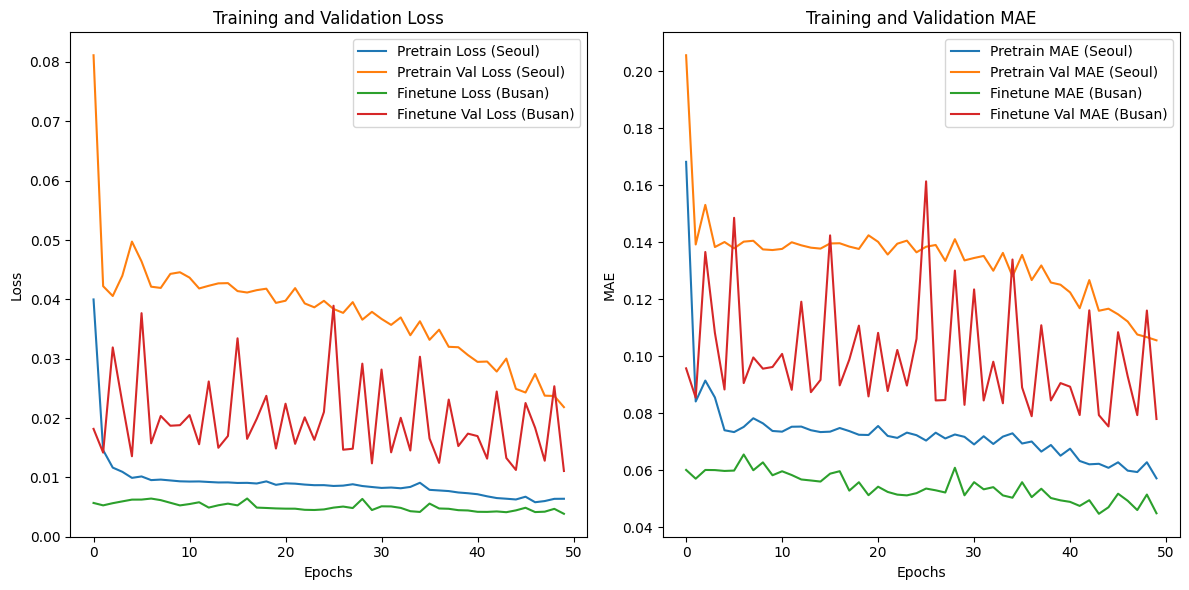

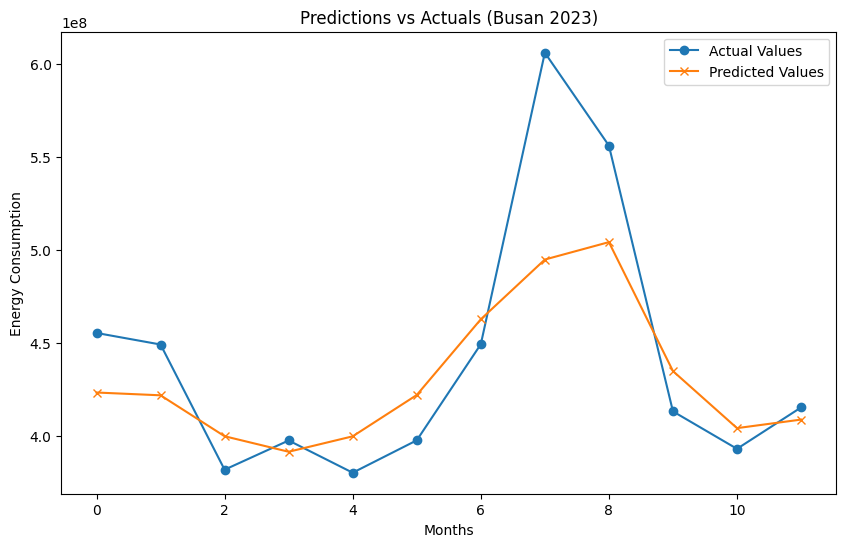

In [ ]:
# 0. Full fine-tune Single variable Model creation backup
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Reshape # Import Reshape

# Define the LSTM model structure
def build_model(window_size):
    input_layer = Input(shape=(window_size,), name='Input')
    # Reshape the input to 3D for the LSTM layer
    reshaped_input = Reshape((window_size, 1))(input_layer)
    lstm_out = LSTM(64, activation='tanh', name='LSTM_Layer')(reshaped_input)

    # Dense layers for final prediction
    dense_1 = Dense(32, activation='relu', name='Dense_1')(lstm_out)
    dense_2 = Dense(16, activation='relu', name='Dense_2')(dense_1)

    # Output layer for predicting the next month's energy consumption
    output_layer = Dense(1, activation='linear', name='Output')(dense_2)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

# Create the LSTM model
model = build_model(WINDOW_SIZE)

# Print model summary
model.summary()

print("Pretraining on Seoul data (2004-2023)...")
history_pretrain = model.fit(X_seoul, y_seoul, epochs=50, batch_size=32, validation_split=0.3)

# Fine-tune the model on Busan's data (train on 2004-2022)
print("Fine-tuning on Busan data (2004-2022)...")
history_finetune = model.fit(X_train_busan, y_train_busan, epochs=50, batch_size=32, validation_split=0.3)

# Test the model on Busan's test data (2023)
print("Testing on Busan data (2023)...")
test_loss, test_mae = model.evaluate(X_test_busan, y_test_busan)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict on the test data
predictions = model.predict(X_test_busan)

# Rescale predictions back to the original Busan scale using the Busan-specific scaler
predictions_rescaled = scaler_busan.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Display the rescaled predictions
print("Predictions for Busan (2023):", predictions_rescaled)

# Also compare the rescaled predictions with the actual values
actual_rescaled = scaler_busan.inverse_transform(y_test_busan.reshape(-1, 1)).flatten()
print("Actual values for Busan (2023):", actual_rescaled)

import matplotlib.pyplot as plt

# 1. Plot training and validation loss during pretraining and fine-tuning
def plot_training_history(history_pretrain, history_finetune):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history_pretrain.history['loss'], label='Pretrain Loss (Seoul)')
    plt.plot(history_pretrain.history['val_loss'], label='Pretrain Val Loss (Seoul)')
    plt.plot(history_finetune.history['loss'], label='Finetune Loss (Busan)')
    plt.plot(history_finetune.history['val_loss'], label='Finetune Val Loss (Busan)')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history_pretrain.history['mae'], label='Pretrain MAE (Seoul)')
    plt.plot(history_pretrain.history['val_mae'], label='Pretrain Val MAE (Seoul)')
    plt.plot(history_finetune.history['mae'], label='Finetune MAE (Busan)')
    plt.plot(history_finetune.history['val_mae'], label='Finetune Val MAE (Busan)')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 2. Plot predictions vs actual values for Busan (2023)
def plot_predictions(y_true, y_pred, title='Predictions vs Actuals (Busan 2023)'):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Values', marker='o')
    plt.plot(y_pred, label='Predicted Values', marker='x')
    plt.title(title)
    plt.xlabel('Months')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.show()

# Call the functions to visualize training and results
plot_training_history(history_pretrain, history_finetune)
plot_predictions(actual_rescaled, predictions_rescaled)

